In [ ]:
# make connection to google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import psutil library to access system resource information
import psutil

ram_gb = psutil.virtual_memory().total / 1e9 # get total ram in bytes and convert to gigabytes
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20: # check if available ram is less than 20 gigabytes
 print('Not using a high-RAM runtime') # notify runtime has low memory
else: # if available ram is 20 gigabytes or more
 print('You are using a high-RAM runtime!') # notify runtime has high memory

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
# set up directory paths to image files
train_path = "/content/drive/My Drive/C-NMC/training_data"
test_path = "/content/drive/My Drive/C-NMC/testing_data/C-NMC_test_final_phase_data"
val_path = "/content/drive/My Drive/C-NMC/validation_data/C-NMC_test_prelim_phase_data"

In [ ]:
# import relevant image and data analysis libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

%matplotlib inline

In [ ]:
healthy_imgs = [] # initialize list to store healthy images
for file in os.listdir(train_path):
  for file2 in os.listdir(os.path.join(train_path, file, "hem")):
    img_path = os.path.join(train_path, file, "hem", file2) # build full image file path

    # load
    img = Image.open(img_path).convert("RGB") # open image and convert to rgb format
    img = img.resize((224, 224)) # resize to 224x224
    healthy_imgs.append(np.array(img, dtype=np.float32)) # convert image to numpy array and append to list

# normalize
healthy_imgs = (np.array(healthy_imgs) / 127.5) - 1.0 # scale pixel values to range [-1.0, 1.0]

In [ ]:
healthy_imgs[0].min() # get minimum pixel value from first normalized healthy image

np.float32(-1.0)

In [ ]:
healthy_imgs[0].max() # get maximum pixel value from first normalized healthy image

np.float32(-0.12941176)

## Filtering out the Data for Faster Training on Smaller Dataset

In [ ]:
# import relevant deep learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose,Cropping2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
# set size of encoding vector to 500
codings_size = 500

In [ ]:
generator = Sequential() # initialize sequential model for generator

# start with a Dense layer and reshape to 7x7x128
generator.add(Dense(7 * 7 * 128, input_shape=[codings_size])) # fully connected layer with output size 7*7*128
generator.add(Reshape([7, 7, 128])) # reshape dense output to 3d volume
generator.add(BatchNormalization()) # normalize activations for faster and more stable training

# first upsampling: 7x7 -> 14x14
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())

# second upsampling: 14x14 -> 28x28
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())

# third upsampling: 28x28 -> 56x56
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())

# fourth upsampling: 56x56 -> 112x112
generator.add(Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())

# fifth upsampling: 112x112 -> 224x224
generator.add(Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())

# output layer
generator.add(Conv2DTranspose(3, kernel_size=5, strides=1, padding="same", activation="tanh")) # output rgb image with values in [-1, 1]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
discriminator = Sequential() # initialize sequential model for discriminator

discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3), input_shape=[224, 224, 3])) # first conv layer with leaky relu and input shape set to 224x224x3
discriminator.add(Dropout(0.5)) # apply dropout to reduce overfitting

discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))

discriminator.add(Flatten()) # flatten feature maps into single vector

discriminator.add(Dense(1, activation="sigmoid")) # output layer with sigmoid for binary classification (real or fake)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# stack generator and discriminator into one sequential model
GAN = Sequential([generator, discriminator])

In [ ]:
optimizer = Adam(learning_rate=0.0002, beta_1=0.5, clipvalue=1.5) # configure adam optimizer with custom hyperparameters
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy']) # compile discriminator with binary crossentropy loss and accuracy metric
discriminator.trainable = True # ensure discriminator is trainable (weights will be updated during training)

In [ ]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.5) # create new adam optimizer with lower learning rate and beta_1 value for smoother updates
GAN.compile(loss="binary_crossentropy", optimizer=optimizer) # compile gan model using binary crossentropy loss and specified optimizer

In [ ]:
# display summary of full gan model with each layer and output shape
GAN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │     3,940,387 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │       611,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,551,588 (17.36 MB)

 Trainable params: 4,550,692 (17.36 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# display summary of generator model
GAN.layers[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │     3,142,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       409,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 56, 56, 64)     │       102,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 112, 112, 32)   │        51,232 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 224, 224, 32)   │        25,632 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 224, 224, 3)    │         2,403 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,940,387 (15.03 MB)

 Trainable params: 3,939,491 (15.03 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# display summary of discriminator model
GAN.layers[1].summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       401,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 611,201 (2.33 MB)

 Trainable params: 611,201 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# function to visualize generated image at given epoch
def epoch_plot(ep, generator, codings_size):
  noise = tf.random.normal(shape=[10, codings_size]) # generate random noise as input for generator
  images = generator(noise) # generate images using generator
  plt.figure(figsize=(4,3))
  img = (images[0].numpy() + 1.0) / 2.0 # convert from [-1,1] to [0,1]
  plt.imshow(img.reshape(224, 224, 3)) # reshape and display the first generated image
  plt.title('Epoch {}'.format(ep+1), fontsize=14)
  plt.show()

# function to plot losses over epochs
def plot_losses(d_losses, g_losses):
  plt.figure(figsize=(10, 5))
  plt.plot(d_losses, label="Discriminator Loss", color='red') # plot discriminator loss
  plt.plot(g_losses, label="Generator Loss", color='blue') # plot generator loss
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.title("Losses during GAN training")
  plt.grid(True)
  plt.show()

### Setting up Training Batches

In [ ]:
# set the batch size for training
batch_size = 32

In [ ]:
# create dataset from healthy images and shuffle
dataset = tf.data.Dataset.from_tensor_slices(healthy_imgs).shuffle(buffer_size=1000)

In [ ]:
# batch dataset and prefetch one batch for performance
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
# set number of training epochs
epochs = 225

In [ ]:
# define training loop for gan using gradient tape
def train_gan_gradient_tape(generator, discriminator, dataset, epochs):
  # set optimizers
  gen_optimizer = Adam(learning_rate=0.0001, beta_1=0.5)
  disc_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, clipvalue=1.5)

  # compile train_step function into tensorflow graph for performance
  @tf.function
  def train_step(real_images): # train generator and discriminator on one batch
    noise = tf.random.normal([batch_size, codings_size]) # generate random noise for generator input

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # record gradients for both networks
      generated_images = generator(noise, training=True) # generate fake images

      real_output = discriminator(real_images, training=True) # get discriminator output for real images
      fake_output = discriminator(generated_images, training=True) # get discriminator output for fake images

      gen_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output) # generator tries to fool discriminator
      gen_loss = tf.reduce_mean(gen_loss) # average generator loss

      disc_loss_real = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) # discriminator loss on real images
      disc_loss_fake = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output) # discriminator loss on fake images
      disc_loss = tf.reduce_mean(disc_loss_real) + tf.reduce_mean(disc_loss_fake) # total discriminator loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # compute generator gradients
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # compute discriminator gradients

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # apply generator gradients
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # apply discriminator gradients

    return gen_loss, disc_loss

  # lists to store losses per epoch
  d_losses = []
  g_losses = []

  # loop through all epochs
  for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")

    # temporary lists for losses in current epoch
    epoch_d_losses = []
    epoch_g_losses = []

    # iterate through each batch in dataset
    for X_batch in dataset:
      # perform training step
      gen_loss, disc_loss = train_step(X_batch)

      # collect losses
      epoch_g_losses.append(gen_loss.numpy())
      epoch_d_losses.append(disc_loss.numpy())

    # compute average losses for epoch
    avg_d_loss = np.mean(epoch_d_losses)
    avg_g_loss = np.mean(epoch_g_losses)

    # append average losses
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)

    # show progress and generated sample every 25 epochs
    if epoch % 25 == 0:
        print(f"Discriminator Loss: {avg_d_loss:.4f}\tGenerator Loss: {avg_g_loss:.4f}")
        epoch_plot(epoch, generator, codings_size)

  return d_losses, g_losses # return list of losses over all epochs

Currently on Epoch 1
Discriminator Loss: 0.2441	Generator Loss: 10.0912


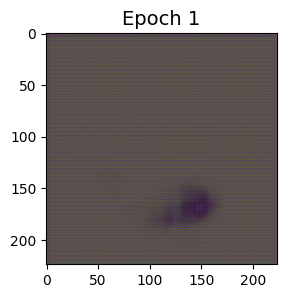

Currently on Epoch 2
Currently on Epoch 3
Currently on Epoch 4
Currently on Epoch 5
Currently on Epoch 6
Currently on Epoch 7
Currently on Epoch 8
Currently on Epoch 9
Currently on Epoch 10
Currently on Epoch 11
Currently on Epoch 12
Currently on Epoch 13
Currently on Epoch 14
Currently on Epoch 15
Currently on Epoch 16
Currently on Epoch 17
Currently on Epoch 18
Currently on Epoch 19
Currently on Epoch 20
Currently on Epoch 21
Currently on Epoch 22
Currently on Epoch 23
Currently on Epoch 24
Currently on Epoch 25
Currently on Epoch 26
Discriminator Loss: 0.6808	Generator Loss: 1.9270


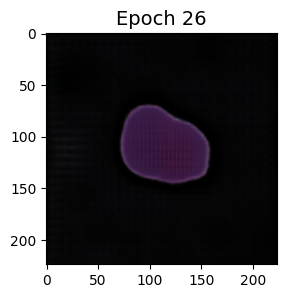

Currently on Epoch 27
Currently on Epoch 28
Currently on Epoch 29
Currently on Epoch 30
Currently on Epoch 31
Currently on Epoch 32
Currently on Epoch 33
Currently on Epoch 34
Currently on Epoch 35
Currently on Epoch 36
Currently on Epoch 37
Currently on Epoch 38
Currently on Epoch 39
Currently on Epoch 40
Currently on Epoch 41
Currently on Epoch 42
Currently on Epoch 43
Currently on Epoch 44
Currently on Epoch 45
Currently on Epoch 46
Currently on Epoch 47
Currently on Epoch 48
Currently on Epoch 49
Currently on Epoch 50
Currently on Epoch 51
Discriminator Loss: 1.2014	Generator Loss: 1.0422


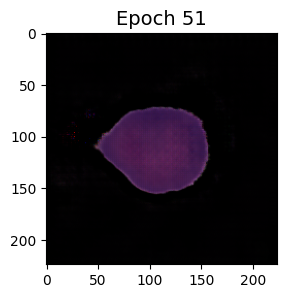

Currently on Epoch 52
Currently on Epoch 53
Currently on Epoch 54
Currently on Epoch 55
Currently on Epoch 56
Currently on Epoch 57
Currently on Epoch 58
Currently on Epoch 59
Currently on Epoch 60
Currently on Epoch 61
Currently on Epoch 62
Currently on Epoch 63
Currently on Epoch 64
Currently on Epoch 65
Currently on Epoch 66
Currently on Epoch 67
Currently on Epoch 68
Currently on Epoch 69
Currently on Epoch 70
Currently on Epoch 71
Currently on Epoch 72
Currently on Epoch 73
Currently on Epoch 74
Currently on Epoch 75
Currently on Epoch 76
Discriminator Loss: 1.2528	Generator Loss: 0.9816


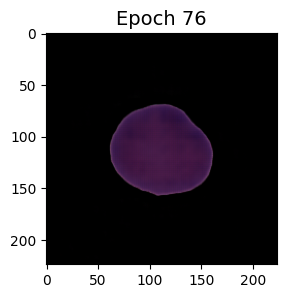

Currently on Epoch 77
Currently on Epoch 78
Currently on Epoch 79
Currently on Epoch 80
Currently on Epoch 81
Currently on Epoch 82
Currently on Epoch 83
Currently on Epoch 84
Currently on Epoch 85
Currently on Epoch 86
Currently on Epoch 87
Currently on Epoch 88
Currently on Epoch 89
Currently on Epoch 90
Currently on Epoch 91
Currently on Epoch 92
Currently on Epoch 93
Currently on Epoch 94
Currently on Epoch 95
Currently on Epoch 96
Currently on Epoch 97
Currently on Epoch 98
Currently on Epoch 99
Currently on Epoch 100
Currently on Epoch 101
Discriminator Loss: 1.3579	Generator Loss: 0.8840


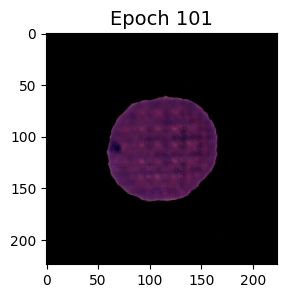

Currently on Epoch 102
Currently on Epoch 103
Currently on Epoch 104
Currently on Epoch 105
Currently on Epoch 106
Currently on Epoch 107
Currently on Epoch 108
Currently on Epoch 109
Currently on Epoch 110
Currently on Epoch 111
Currently on Epoch 112
Currently on Epoch 113
Currently on Epoch 114
Currently on Epoch 115
Currently on Epoch 116
Currently on Epoch 117
Currently on Epoch 118
Currently on Epoch 119
Currently on Epoch 120
Currently on Epoch 121
Currently on Epoch 122
Currently on Epoch 123
Currently on Epoch 124
Currently on Epoch 125
Currently on Epoch 126
Discriminator Loss: 1.3605	Generator Loss: 0.8997


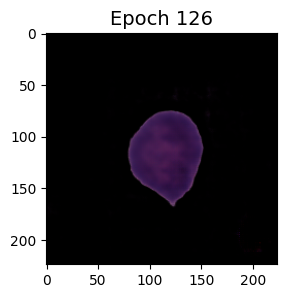

Currently on Epoch 127
Currently on Epoch 128
Currently on Epoch 129
Currently on Epoch 130
Currently on Epoch 131
Currently on Epoch 132
Currently on Epoch 133
Currently on Epoch 134
Currently on Epoch 135
Currently on Epoch 136
Currently on Epoch 137
Currently on Epoch 138
Currently on Epoch 139
Currently on Epoch 140
Currently on Epoch 141
Currently on Epoch 142
Currently on Epoch 143
Currently on Epoch 144
Currently on Epoch 145
Currently on Epoch 146
Currently on Epoch 147
Currently on Epoch 148
Currently on Epoch 149
Currently on Epoch 150
Currently on Epoch 151
Discriminator Loss: 1.3684	Generator Loss: 0.8665


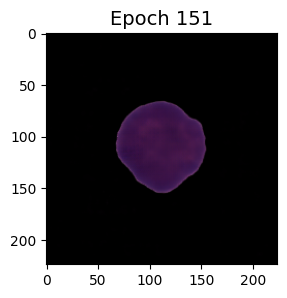

Currently on Epoch 152
Currently on Epoch 153
Currently on Epoch 154
Currently on Epoch 155
Currently on Epoch 156
Currently on Epoch 157
Currently on Epoch 158
Currently on Epoch 159
Currently on Epoch 160
Currently on Epoch 161
Currently on Epoch 162
Currently on Epoch 163
Currently on Epoch 164
Currently on Epoch 165
Currently on Epoch 166
Currently on Epoch 167
Currently on Epoch 168
Currently on Epoch 169
Currently on Epoch 170
Currently on Epoch 171
Currently on Epoch 172
Currently on Epoch 173
Currently on Epoch 174
Currently on Epoch 175
Currently on Epoch 176
Discriminator Loss: 1.4077	Generator Loss: 0.9042


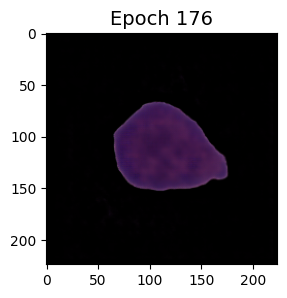

Currently on Epoch 177
Currently on Epoch 178
Currently on Epoch 179
Currently on Epoch 180
Currently on Epoch 181
Currently on Epoch 182
Currently on Epoch 183
Currently on Epoch 184
Currently on Epoch 185
Currently on Epoch 186
Currently on Epoch 187
Currently on Epoch 188
Currently on Epoch 189
Currently on Epoch 190
Currently on Epoch 191
Currently on Epoch 192
Currently on Epoch 193
Currently on Epoch 194
Currently on Epoch 195
Currently on Epoch 196
Currently on Epoch 197
Currently on Epoch 198
Currently on Epoch 199
Currently on Epoch 200
Currently on Epoch 201
Discriminator Loss: 1.3422	Generator Loss: 0.8604


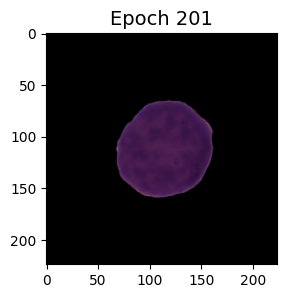

Currently on Epoch 202
Currently on Epoch 203
Currently on Epoch 204
Currently on Epoch 205
Currently on Epoch 206
Currently on Epoch 207
Currently on Epoch 208
Currently on Epoch 209
Currently on Epoch 210
Currently on Epoch 211
Currently on Epoch 212
Currently on Epoch 213
Currently on Epoch 214
Currently on Epoch 215
Currently on Epoch 216
Currently on Epoch 217
Currently on Epoch 218
Currently on Epoch 219
Currently on Epoch 220
Currently on Epoch 221
Currently on Epoch 222
Currently on Epoch 223
Currently on Epoch 224
Currently on Epoch 225


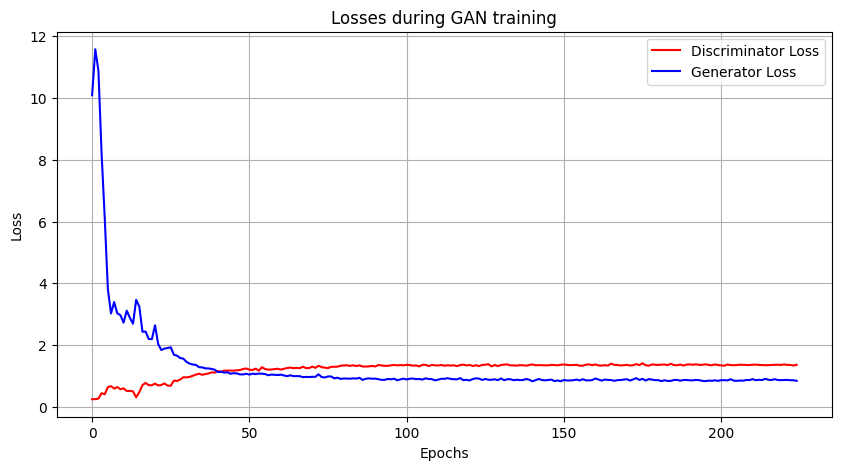

In [ ]:
# train gan and store loss histories for both networks
d_losses, g_losses = train_gan_gradient_tape(generator, discriminator, dataset, epochs)

# visualize generator and discriminator losses over training
plot_losses(d_losses, g_losses)

In [ ]:
# example noise to test generator after training
noise = tf.random.normal(shape=[10, codings_size])

In [ ]:
# get images based on trained generator
images = generator(noise)

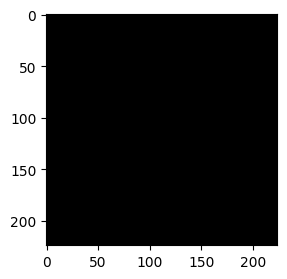

In [ ]:
# show example of expected generator output
plt.figure(figsize=(4,3))
plt.imshow(healthy_imgs[0])

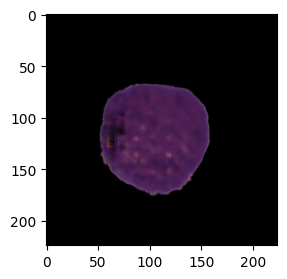

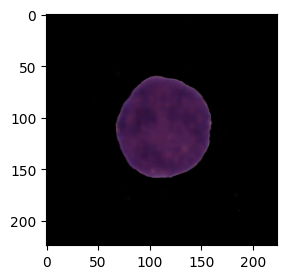

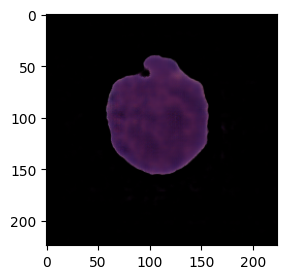

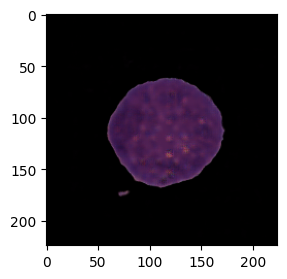

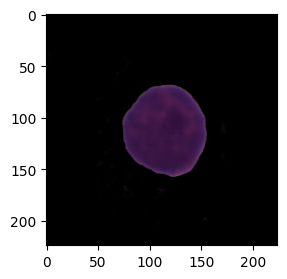

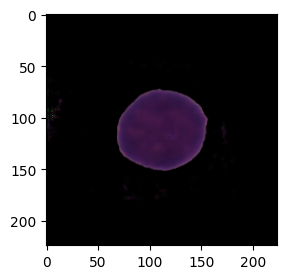

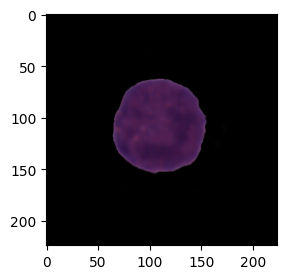

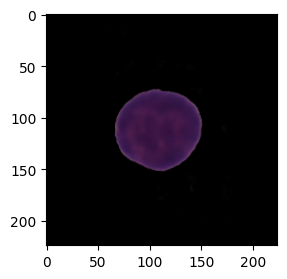

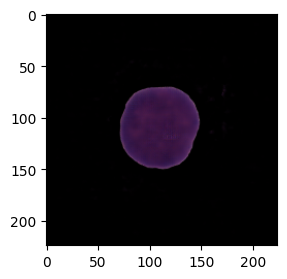

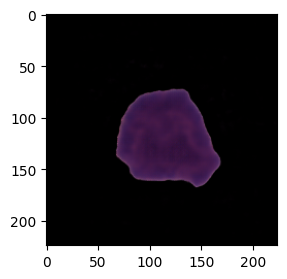

In [ ]:
# loop to plot generated images
for image in images:
    plt.figure(figsize=(4,3))
    img = (image.numpy() + 1.0) / 2.0 # convert from [-1,1] to [0,1]
    plt.imshow(img.reshape(224, 224, 3))
    plt.show()
    print("\n")

In [ ]:
# save models
generator.save("generator_model.keras")
discriminator.save("discriminator_model.keras")

In [ ]:
# save model weights
generator.save_weights("generator_weights.weights.h5")
discriminator.save_weights("discriminator_weights.weights.h5")